### Historcial Data Recorder for Gemini Exchange

In [1]:
#import necessary packages
import zmq   # message broadcasting/receiving protocol 
import datetime   # datetime libraries
import pandas as pd  # data manipulation 
import numpy as np
import tables as tb  # data storage
import tstables as ts # fast data storage, write once/read many optimised
import pygem as pg  # wrapper class for gemini rest api
import configparser # initialise login details via config file
import pygem_socket as pgs
import time
import threading   # multiprocessing library
from threading import Timer,Thread,Event
%matplotlib inline
import matplotlib.pyplot as plt
import matplotlib
plt.style.use('seaborn')
import pandas as pd
import json
from statsmodels import regression
#
import statsmodels.api as sm


# set output to be single line
pd.set_option('display.expand_frame_repr', False)
matplotlib.rcParams['figure.figsize'] = (10.0, 7.0)


jtplot.style(theme='chesterish')

pd.options.mode.chained_assignment = None
pd.set_option('display.max_columns', 500)


In [2]:

# Connection to gemini exchange
profile = configparser.ConfigParser()
profile.read('LIVE_pyalgo.cfg')
con_rest = pg.pygem(profile['gemini']['key'], profile['gemini']['secret_key'], debug=False)
con_socket = pgs.pygem_socket(profile['gemini']['key'], profile['gemini']['secret_key'],debug=False)

In [3]:
coin = 'BTC'

In [4]:
coin_low = coin.lower()
coinpair = f'{coin}USD'
coinpair_low = coinpair.lower()
print(f'coin= {coin}')
print(f'coin_low= {coin_low}')
print(f'coinpair= {coinpair}')
print(f'coinpair_low= {coinpair_low}')

coin= BTC
coin_low= btc
coinpair= BTCUSD
coinpair_low= btcusd


### SERVER DATA

In [ ]:
file_path = f'root@178.62.43.173:/root/tick_data_storage/data_files/df_{coinpair_low}_data.h5'
!pscp $file_path .

In [ ]:
initial_f = f'df_{coinpair_low}_data.h5'
working_f = f'old_df_{coinpair_low}_data.h5'
!mv $initial_f $working_f

In [5]:
h1 = pd.HDFStore(f'old_df_{coinpair_low}_data.h5','r')
df_data =h1[f'df_{coinpair_low}_data']

In [6]:
df_data.head()

,bid_side,ask_side,auction,USD_price,BTC_amount
2015-10-08 14:40:07,1.0,0.0,0.0,242.50,0.050000
2015-10-08 14:41:35,1.0,0.0,0.0,242.95,0.001000
2015-10-08 14:43:41,0.0,1.0,0.0,242.96,0.010000
2015-10-08 14:44:14,1.0,0.0,0.0,242.96,0.033491
2015-10-08 14:46:46,1.0,0.0,0.0,242.96,0.004000


In [7]:
start = '2010-01-01 0:00:00' 
end = '2020-11-18 17:25:13'

In [8]:
df_data = df_data[start:end]

In [9]:
df_data.head()

,bid_side,ask_side,auction,USD_price,BTC_amount
2015-10-08 14:40:07,1.0,0.0,0.0,242.50,0.050000
2015-10-08 14:41:35,1.0,0.0,0.0,242.95,0.001000
2015-10-08 14:43:41,0.0,1.0,0.0,242.96,0.010000
2015-10-08 14:44:14,1.0,0.0,0.0,242.96,0.033491
2015-10-08 14:46:46,1.0,0.0,0.0,242.96,0.004000


In [10]:
df_data.tail()

,bid_side,ask_side,auction,USD_price,BTC_amount
2019-12-16 20:55:12.927,1.0,0.0,0.0,6838.95,0.350000
2019-12-16 20:55:14.832,0.0,1.0,0.0,6842.66,0.035814
2019-12-16 20:55:16.785,1.0,0.0,0.0,6841.42,0.000010
2019-12-16 20:55:19.366,0.0,1.0,0.0,6842.66,0.960000
2019-12-16 20:55:19.367,0.0,1.0,0.0,6842.66,0.004186


In [11]:
df_data.index.is_monotonic

False

In [12]:
df_data.index  = df_data.index.floor('s')

In [13]:
df_data.index.is_monotonic

False

In [14]:
len(df_data)

10385292

In [15]:
test = df_data[df_data[f'{coin}_amount']>750]
test = test[(test['auction'] ==0)]
test.head()

,bid_side,ask_side,auction,USD_price,BTC_amount
2017-03-02 15:36:03,0.0,1.0,0.0,1255.0,1252.54441
2017-03-02 17:57:18,0.0,1.0,0.0,1283.0,1000.00000
2017-03-02 17:57:18,0.0,1.0,0.0,1285.0,1000.00000
2017-03-02 17:57:18,0.0,1.0,0.0,1285.0,1000.00000
2017-03-02 17:57:26,1.0,0.0,0.0,1285.0,1000.00000


### Check of tail line of data

In [16]:
df_data.tail()

,bid_side,ask_side,auction,USD_price,BTC_amount
2019-12-16 20:55:12,1.0,0.0,0.0,6838.95,0.350000
2019-12-16 20:55:14,0.0,1.0,0.0,6842.66,0.035814
2019-12-16 20:55:16,1.0,0.0,0.0,6841.42,0.000010
2019-12-16 20:55:19,0.0,1.0,0.0,6842.66,0.960000
2019-12-16 20:55:19,0.0,1.0,0.0,6842.66,0.004186


In [17]:
initial_start = df_data.index[-1]

In [18]:
check_start = initial_start - datetime.timedelta(seconds=1)

In [19]:
data1 = con_rest.get_trades_history(coinpair_low, since=check_start,
                             limit_trades=500, include_breaks=False)

In [20]:
data1.head()

,amount,exchange,price,tid,timestamp,timestampms,type
datetime,,,,,,,
2019-12-16 20:55:19,0.960000,gemini,6842.66,9123854956,1576529719,1576529719366,buy
2019-12-16 20:55:19,0.004186,gemini,6842.66,9123854961,1576529719,1576529719367,buy
2019-12-16 20:55:37,0.145596,gemini,6843.90,9123861963,1576529737,1576529737706,buy
2019-12-16 20:55:37,0.000010,gemini,6840.28,9123861961,1576529737,1576529737706,buy
2019-12-16 20:55:41,0.000010,gemini,6840.27,9123863302,1576529741,1576529741308,sell


### Visual test of data

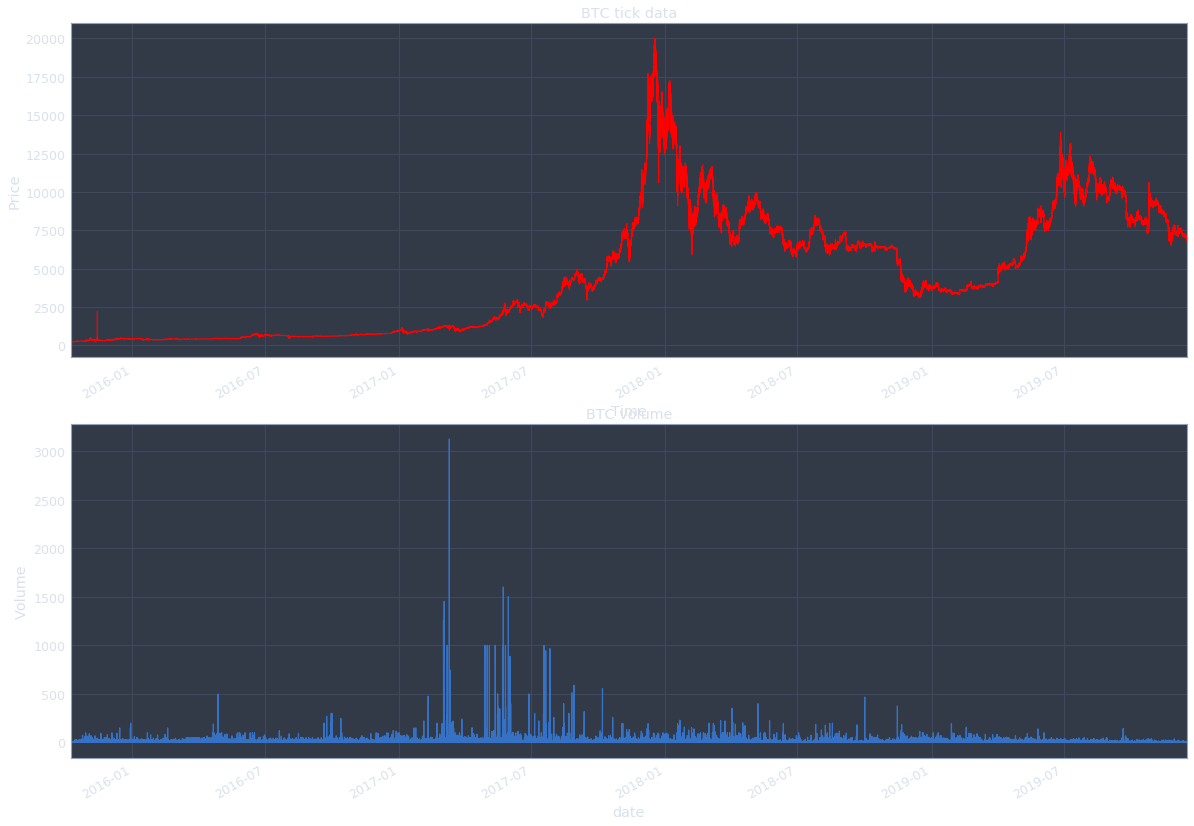

In [21]:
tickdata_graph = df_data
tickdata_graph = tickdata_graph[(tickdata_graph['auction'] ==0)]

plt.figure(figsize=(20,15))
plt.subplots_adjust(hspace=0.2,wspace=0.1)

plt.subplot(211)
tickdata_graph['USD_price'].plot(color='Red')
plt.xlabel('Time')
plt.ylabel('Price')
plt.title(f'{coin} tick data')
plt.grid(True)

plt.subplot(212)
tickdata_graph[f'{coin}_amount'].plot()
plt.xlabel('date')
plt.ylabel('Volume')
plt.title(f'{coin} volume')
plt.grid(True)


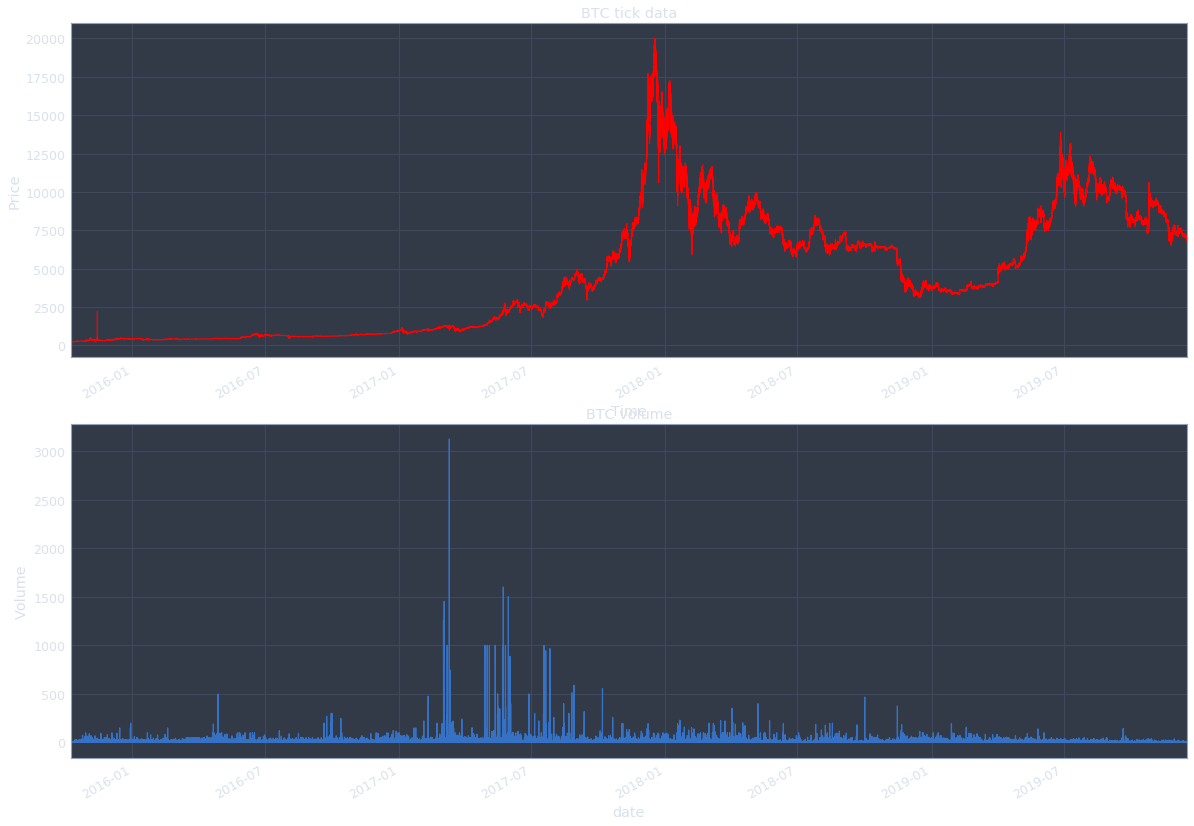

In [22]:
tickdata_graph = df_data
tickdata_graph = tickdata_graph[(tickdata_graph['auction'] ==0)]

plt.figure(figsize=(20,15))
plt.subplots_adjust(hspace=0.2,wspace=0.1)

plt.subplot(211)
tickdata_graph['USD_price'].plot(color='Red')
plt.xlabel('Time')
plt.ylabel('Price')
plt.title(f'{coin} tick data')
plt.grid(True)

plt.subplot(212)
tickdata_graph[f'{coin}_amount'].plot()
plt.xlabel('date')
plt.ylabel('Volume')
plt.title(f'{coin} volume')
plt.grid(True)


### EXCHANGE DATA

In [23]:
exchange_start = initial_start + datetime.timedelta(seconds=1)
start         = exchange_start
end           = datetime.datetime(2025, 1, 1, 1, 1, 1)

In [24]:
#check_time = datetime.datetime.now().replace(microsecond=0)
data=pd.DataFrame()
length=0
while start < end:
    trades = con_rest.get_trades_history(coinpair_low, since=start,
                             limit_trades=500, include_breaks=False)
    length = length+len(trades)
    print('length= ', length)
    if len(trades)==0:
        break
    data = data.append(trades)
    start = data.index[-1]
    start = start + datetime.timedelta(seconds=1)
    print(start)

length=  500
2019-12-16 22:19:44
length=  1000
2019-12-17 00:08:08
length=  1500
2019-12-17 04:24:45
length=  2000
2019-12-17 08:05:13
length=  2500
2019-12-17 11:53:19
length=  3000
2019-12-17 13:44:43
length=  3500
2019-12-17 14:11:14
length=  4000
2019-12-17 14:42:37
length=  4500
2019-12-17 15:58:07
length=  5000
2019-12-17 16:45:43
length=  5500
2019-12-17 18:10:09
length=  6000
2019-12-17 19:34:19
length=  6500
2019-12-17 20:15:24
length=  7000
2019-12-17 21:10:32
length=  7500
2019-12-17 22:28:30
length=  8000
2019-12-17 23:29:18
length=  8500
2019-12-18 01:11:00
length=  9000
2019-12-18 03:18:26
length=  9500
2019-12-18 05:35:10
length=  10000
2019-12-18 08:00:28
length=  10500
2019-12-18 11:18:07
length=  11000
2019-12-18 12:51:44
length=  11500
2019-12-18 13:07:35
length=  12000
2019-12-18 13:43:56
length=  12500
2019-12-18 14:43:33
length=  13000
2019-12-18 15:30:08
length=  13500
2019-12-18 16:24:09
length=  14000
2019-12-18 17:37:07
length=  14500
2019-12-18 19:00:51
lengt

In [25]:
data.head()

,amount,exchange,price,tid,timestamp,timestampms,type
datetime,,,,,,,
2019-12-16 20:55:37,0.000010,gemini,6840.28,9123861961,1576529737,1576529737706,buy
2019-12-16 20:55:37,0.145596,gemini,6843.90,9123861963,1576529737,1576529737706,buy
2019-12-16 20:55:41,0.000010,gemini,6840.27,9123863302,1576529741,1576529741308,sell
2019-12-16 20:55:46,0.008800,gemini,6840.28,9123864930,1576529746,1576529746854,buy
2019-12-16 20:55:52,0.028628,gemini,6851.38,9123866466,1576529752,1576529752268,buy


In [26]:
data.tail()

,amount,exchange,price,tid,timestamp,timestampms,type
datetime,,,,,,,
2019-12-18 22:45:02,0.017018,gemini,7182.16,9148302402,1576709102,1576709102581,buy
2019-12-18 22:45:06,0.000010,gemini,7181.75,9148302668,1576709106,1576709106116,sell
2019-12-18 22:48:11,0.000160,gemini,7212.38,9148328953,1576709291,1576709291726,buy
2019-12-18 22:48:18,0.000010,gemini,7202.63,9148329933,1576709298,1576709298649,buy
2019-12-18 22:48:18,0.019300,gemini,7202.63,9148329935,1576709298,1576709298649,buy


In [27]:
len(data)

16693

In [28]:
data.index.is_monotonic

True

In [29]:
data1 = con_rest.get_trades_history(coinpair_low, since=exchange_start,
                             limit_trades=500, include_breaks=False)

In [30]:
data1.head()

,amount,exchange,price,tid,timestamp,timestampms,type
datetime,,,,,,,
2019-12-16 20:55:37,0.000010,gemini,6840.28,9123861961,1576529737,1576529737706,buy
2019-12-16 20:55:37,0.145596,gemini,6843.90,9123861963,1576529737,1576529737706,buy
2019-12-16 20:55:41,0.000010,gemini,6840.27,9123863302,1576529741,1576529741308,sell
2019-12-16 20:55:46,0.008800,gemini,6840.28,9123864930,1576529746,1576529746854,buy
2019-12-16 20:55:52,0.028628,gemini,6851.38,9123866466,1576529752,1576529752268,buy


In [31]:
data_repair=pd.DataFrame()
data_repair['bid_side']=(data['type'] =='sell').astype('float')
data_repair['ask_side']=(data['type'] =='buy').astype('float')
data_repair['auction']=(data['type'] =='auction').astype('float')
data_repair['USD_price']=data['price']
data_repair[f'{coin}_amount']=data['amount']  

In [32]:
data_repair.head()

,bid_side,ask_side,auction,USD_price,BTC_amount
datetime,,,,,
2019-12-16 20:55:37,0.0,1.0,0.0,6840.28,0.000010
2019-12-16 20:55:37,0.0,1.0,0.0,6843.90,0.145596
2019-12-16 20:55:41,1.0,0.0,0.0,6840.27,0.000010
2019-12-16 20:55:46,0.0,1.0,0.0,6840.28,0.008800
2019-12-16 20:55:52,0.0,1.0,0.0,6851.38,0.028628


In [33]:
data_repair.tail()

,bid_side,ask_side,auction,USD_price,BTC_amount
datetime,,,,,
2019-12-18 22:45:02,0.0,1.0,0.0,7182.16,0.017018
2019-12-18 22:45:06,1.0,0.0,0.0,7181.75,0.000010
2019-12-18 22:48:11,0.0,1.0,0.0,7212.38,0.000160
2019-12-18 22:48:18,0.0,1.0,0.0,7202.63,0.000010
2019-12-18 22:48:18,0.0,1.0,0.0,7202.63,0.019300


### Current Data

In [34]:
tickdata = df_data

In [35]:
tickdata.head()

,bid_side,ask_side,auction,USD_price,BTC_amount
2015-10-08 14:40:07,1.0,0.0,0.0,242.50,0.050000
2015-10-08 14:41:35,1.0,0.0,0.0,242.95,0.001000
2015-10-08 14:43:41,0.0,1.0,0.0,242.96,0.010000
2015-10-08 14:44:14,1.0,0.0,0.0,242.96,0.033491
2015-10-08 14:46:46,1.0,0.0,0.0,242.96,0.004000


In [36]:
tickdata.tail()

,bid_side,ask_side,auction,USD_price,BTC_amount
2019-12-16 20:55:12,1.0,0.0,0.0,6838.95,0.350000
2019-12-16 20:55:14,0.0,1.0,0.0,6842.66,0.035814
2019-12-16 20:55:16,1.0,0.0,0.0,6841.42,0.000010
2019-12-16 20:55:19,0.0,1.0,0.0,6842.66,0.960000
2019-12-16 20:55:19,0.0,1.0,0.0,6842.66,0.004186


In [37]:
df_data_final=pd.DataFrame()
df_data_final = tickdata.append(data_repair)

In [38]:
df_data_final.head()

,bid_side,ask_side,auction,USD_price,BTC_amount
2015-10-08 14:40:07,1.0,0.0,0.0,242.50,0.050000
2015-10-08 14:41:35,1.0,0.0,0.0,242.95,0.001000
2015-10-08 14:43:41,0.0,1.0,0.0,242.96,0.010000
2015-10-08 14:44:14,1.0,0.0,0.0,242.96,0.033491
2015-10-08 14:46:46,1.0,0.0,0.0,242.96,0.004000


In [39]:
df_data_final.tail()

,bid_side,ask_side,auction,USD_price,BTC_amount
2019-12-18 22:45:02,0.0,1.0,0.0,7182.16,0.017018
2019-12-18 22:45:06,1.0,0.0,0.0,7181.75,0.000010
2019-12-18 22:48:11,0.0,1.0,0.0,7212.38,0.000160
2019-12-18 22:48:18,0.0,1.0,0.0,7202.63,0.000010
2019-12-18 22:48:18,0.0,1.0,0.0,7202.63,0.019300


In [40]:
df_data_final.index.is_monotonic

False

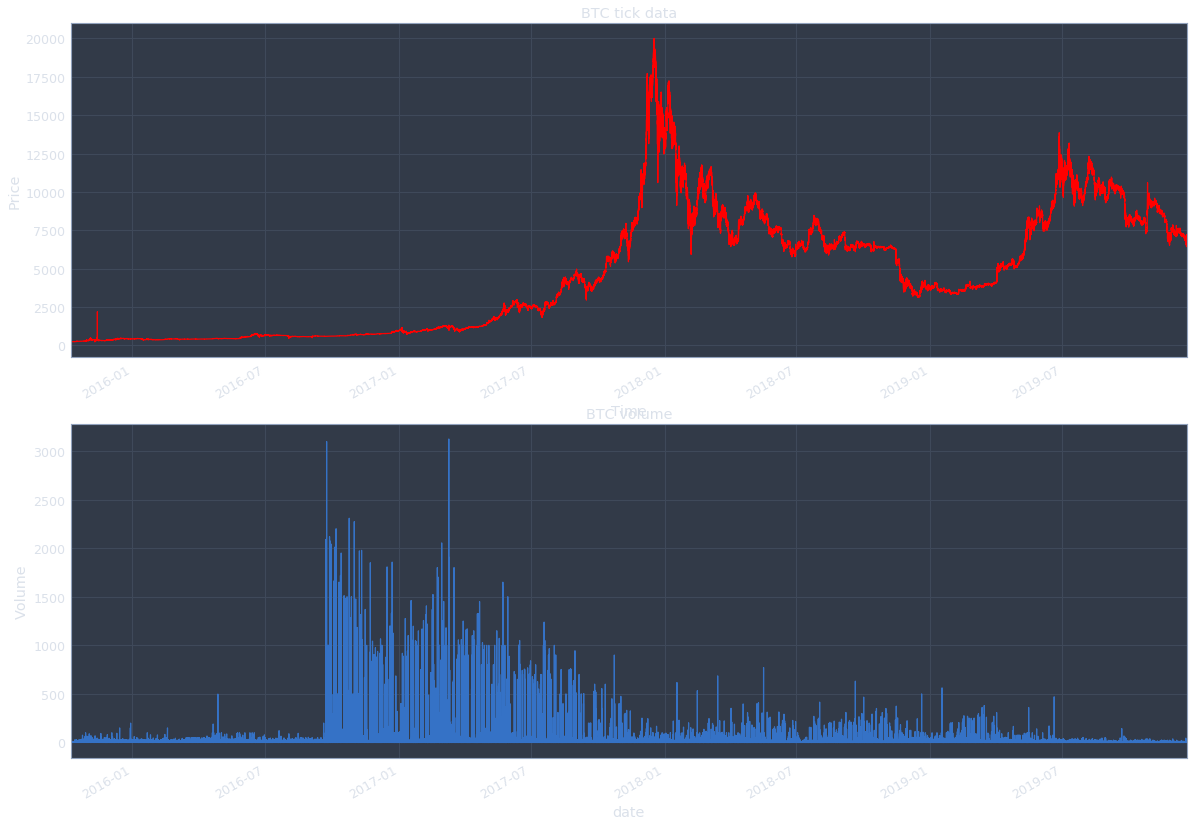

In [41]:
tickdata_graph = df_data_final
#tickdata_graph = tickdata_graph[(tickdata_graph['auction'] ==0)]

plt.figure(figsize=(20,15))
plt.subplots_adjust(hspace=0.2,wspace=0.1)

plt.subplot(211)
tickdata_graph['USD_price'].plot(color='Red')
plt.xlabel('Time')
plt.ylabel('Price')
plt.title(f'{coin} tick data')
plt.grid(True)

plt.subplot(212)
tickdata_graph[f'{coin}_amount'].plot()
plt.xlabel('date')
plt.ylabel('Volume')
plt.title(f'{coin} volume')
plt.grid(True)


In [42]:
h6 = pd.HDFStore(f'df_{coinpair_low}_data.h5', 'a')
h6.append(f'df_{coinpair_low}_data', df_data_final, min_itemsize=10 )
h6.close

<bound method HDFStore.close of <class 'pandas.io.pytables.HDFStore'>
File path: df_btcusd_data.h5
>

In [43]:
dest_path = f'/home/martin/linux_shared/algo_trading/gemini_project/tick_data_storage/tick_repair/{coinpair_low}/df_{coinpair_low}_data.h5'

In [44]:
!pscp $dest_path root@178.62.43.173:

df_btcusd_data.h5         | 513443 kB | 1746.4 kB/s | ETA: 00:00:00 | 100%


In [45]:
tb.file._open_files.close_all()

Closing remaining open files:old_df_btcusd_data.h5...donedf_btcusd_data.h5...done


In [46]:
!rm $initial_f $working_f

rm: missing operand
Try 'rm --help' for more information.
